In [1]:
%load_ext autoreload
%autoreload 2

import torch

from mingpt.utils import set_seed
from mingpt.trainer import Trainer, PrefixTrainer
from mingpt.model import GPT
from mingpt.data_tools import CustomDataset, eval, batch_end_callback, attention_visualization

import seaborn as sns
import matplotlib.pyplot as plt
from typing import Optional, List

set_seed(2023)

We want to see if a model pre-trained on one task can be prefix-tuned to do another task which requires a different attention pattern.
Concretely, we will pre-train a model to sort numbers in ascending order.
We will then show that we can easily fine-tune it to sort in descending order.
However, we will have no success whatsoever finding a prefix that causes the model to sort in descending order.

First let's prepare our datasets:

In [2]:
prefix_size = 1
train_dataset_asc = CustomDataset('train', mode="ascending", prefix_padding=prefix_size)
test_dataset_asc = CustomDataset('test', mode="ascending", prefix_padding=prefix_size)
train_dataset_desc = CustomDataset('train', mode="descending", prefix_padding=prefix_size)
test_dataset_desc = CustomDataset('test', mode="descending", prefix_padding=prefix_size)

print("> Sample from the ascending dataset:")
x, y = train_dataset_asc[0]
print("".join(map(lambda x: f"{x:>4}", x.tolist())))
print("".join(map(lambda x: f"{x:>4}", y.tolist())))
print("> Sample from the descending dataset:")
x, y = train_dataset_desc[0]
print("".join(map(lambda x: f"{x:>4}", x.tolist())))
print("".join(map(lambda x: f"{x:>4}", y.tolist())))

> Sample from the ascending dataset:
   0   7   1   6   7   1   4   3   4   4   6   1   1   3   4   4   4   6   6   7
  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1   1   1   3   4   4   4   6   6   7   7
> Sample from the descending dataset:
   0   3   2   4   1   6   0   7   7   1   0   7   7   6   4   3   2   1   1   0
  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1   7   7   6   4   3   2   1   1   0   0


Let's pre-train the model on `train_dataset_asc` and check its accuracy:

In [3]:
# create a GPT instance
model_config = GPT.get_default_config()
model_config.model_type = None
model_config.vocab_size = train_dataset_asc.get_vocab_size()
model_config.block_size = train_dataset_asc.get_block_size()
model_config.n_layer = 1
model_config.n_head = 1
model_config.n_embd = 96
model = GPT(model_config)

# create a Trainer object
train_config = Trainer.get_default_config()
train_config.learning_rate = 5e-4
train_config.max_iters = 20000
train_config.num_workers = 0
trainer = Trainer(train_config, model, train_dataset_asc)
trainer.set_callback('on_batch_end', batch_end_callback)
trainer.run()
device = trainer.device

# save the model weights:
torch.save(model.state_dict(), '01_sort.pth')

number of parameters: 0.13M
running on device cuda
iter_dt   2.81ms; iter   1000: train loss 0.30005
iter_dt   2.79ms; iter   2000: train loss 0.30676
iter_dt   2.73ms; iter   3000: train loss 0.20130
iter_dt   2.78ms; iter   4000: train loss 0.16737
iter_dt   2.77ms; iter   5000: train loss 0.18103
iter_dt   2.82ms; iter   6000: train loss 0.16501
iter_dt   2.83ms; iter   7000: train loss 0.14258
iter_dt   2.73ms; iter   8000: train loss 0.19052
iter_dt   2.47ms; iter   9000: train loss 0.13781
iter_dt   2.77ms; iter  10000: train loss 0.16482
iter_dt   2.90ms; iter  11000: train loss 0.13708
iter_dt   2.90ms; iter  12000: train loss 0.15167
iter_dt   2.94ms; iter  13000: train loss 0.11901
iter_dt   2.83ms; iter  14000: train loss 0.14067
iter_dt   2.92ms; iter  15000: train loss 0.14187
iter_dt   2.91ms; iter  16000: train loss 0.10635
iter_dt   2.97ms; iter  17000: train loss 0.12631
iter_dt   3.02ms; iter  18000: train loss 0.16232
iter_dt   2.89ms; iter  19000: train loss 0.15011

In [15]:
print(f"Test performance on ascending ", end="")
_ = eval(model, dataset=test_dataset_asc, device=device, max_batches=32)

print(f"Test performance on descending ", end="")
_ = eval(model, dataset=test_dataset_desc, device=device, max_batches=32)

Test performance on ascending Final score: 2925/3200 = 91.41% correct
Test performance on descending Final score: 0/3200 = 0.00% correct


And we can also take a look at the attention patterns of the heads and verify that they indeed first look at the smaller numbers and as they near the end of the sorted sequence attend more to the larger numbers.
Note that the `prefix` section is only zeros at this point.

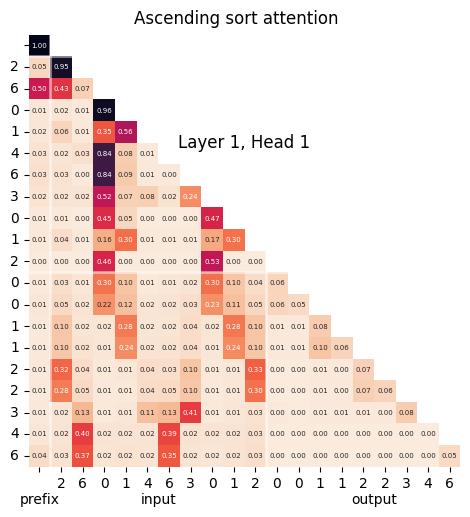

In [5]:
record = []
continuation = model.generate(torch.tensor([0]*prefix_size + [2,6,0,1,4,6,3,0,1,2], device=device).unsqueeze(0), 10, do_sample=False, activations_record=record)
attention_visualization(continuation[0].cpu(), record, prefix_size, train_dataset_desc.length, title="Ascending sort attention")
plt.savefig("01_pretrained.pdf")

Now, let's see what happens if we fine-tune this model on descending sorted data for a fraction of the pre-training iterations:

In [6]:
# load the model from the stored weights:
model_ft = GPT(model_config)
model_ft.load_state_dict(torch.load('01_sort.pth'))
train_config.max_iters = 10000
trainer = Trainer(train_config, model_ft, train_dataset_desc)
trainer.set_callback('on_batch_end', batch_end_callback)
trainer.run()

number of parameters: 0.13M
running on device cuda
iter_dt   2.98ms; iter   1000: train loss 0.20776
iter_dt   3.09ms; iter   2000: train loss 0.12693
iter_dt   3.13ms; iter   3000: train loss 0.15663
iter_dt   3.06ms; iter   4000: train loss 0.12076
iter_dt   3.13ms; iter   5000: train loss 0.12448
iter_dt   2.94ms; iter   6000: train loss 0.12807
iter_dt   2.90ms; iter   7000: train loss 0.09023
iter_dt   3.02ms; iter   8000: train loss 0.08862
iter_dt   2.97ms; iter   9000: train loss 0.10555
iter_dt   3.25ms; iter  10000: train loss 0.09848


In [16]:
print(f"Test performance on ascending ", end="")
_ = eval(model_ft, dataset=test_dataset_asc, device=device, max_batches=32)

print(f"Test performance on descending ", end="")
_ = eval(model_ft, dataset=test_dataset_desc, device=device, max_batches=32)

Test performance on ascending Final score: 0/3200 = 0.00% correct
Test performance on descending Final score: 2717/3200 = 84.91% correct


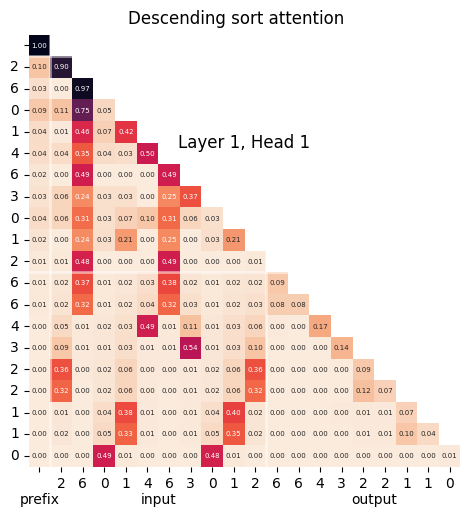

In [9]:
record = []
continuation = model_ft.generate(torch.tensor([0]*prefix_size + [2,6,0,1,4,6,3,0,1,2], device=device).unsqueeze(0), 10, do_sample=False, activations_record=record)
attention_visualization(continuation[0].cpu(), record, prefix_size, train_dataset_desc.length, title="Descending sort attention")
plt.savefig("01_finetuned.pdf")

Hence reversing the sorting order is very easy via full fine-tuning. The attention pattern is also changed: now the heads first attend to large values and later to the smaller ones.

But can we get a prefix that does the same? Let's see. Note how we train the prefix for 4 times more iterations than the pre-training and 10 times more than the fine-tuning. Still, the accuracy on the descending sort task is 0.

In [10]:
prefixes = torch.randn((model_config.n_layer, prefix_size, model_config.n_embd), requires_grad=True, device=trainer.device)

train_config.max_iters = 40000
trainer = PrefixTrainer(train_config, model, train_dataset_desc, prefixes)
trainer.set_callback('on_batch_end', batch_end_callback)
trainer.run()

running on device cuda
iter_dt   2.87ms; iter   1000: train loss 8.63095
iter_dt   2.83ms; iter   2000: train loss 7.43962
iter_dt   3.08ms; iter   3000: train loss 6.75207
iter_dt   2.99ms; iter   4000: train loss 6.27138
iter_dt   2.92ms; iter   5000: train loss 6.08952
iter_dt   2.90ms; iter   6000: train loss 5.89661
iter_dt   2.92ms; iter   7000: train loss 5.89542
iter_dt   2.83ms; iter   8000: train loss 5.71310
iter_dt   3.00ms; iter   9000: train loss 5.56893
iter_dt   2.75ms; iter  10000: train loss 5.42683
iter_dt   2.71ms; iter  11000: train loss 5.31415
iter_dt   2.96ms; iter  12000: train loss 5.49082
iter_dt   2.99ms; iter  13000: train loss 5.32619
iter_dt   2.68ms; iter  14000: train loss 5.28598
iter_dt   2.86ms; iter  15000: train loss 5.24930
iter_dt   3.00ms; iter  16000: train loss 5.46504
iter_dt   2.93ms; iter  17000: train loss 5.26774
iter_dt   2.89ms; iter  18000: train loss 5.56882
iter_dt   2.89ms; iter  19000: train loss 5.23798
iter_dt   2.96ms; iter  200

In [18]:
print(f"Test performance on descending ", end="")
_ = eval(model, dataset=test_dataset_desc, device=device, max_batches=32, prefixes=prefixes)
print(f"Test performance on ascending ", end="")
_ = eval(model, dataset=test_dataset_asc, device=device, max_batches=32, prefixes=prefixes)

Test performance on descending Final score: 0/3200 = 0.00% correct
Test performance on ascending Final score: 3/3200 = 0.09% correct


Finally, despite the presence of the prefix and it changing the attention pattern of the first 10 positions, the attention pattern over the input is not changed and the model still attends first to the smaller values.
Therefore, this supports our theoretical results that a prefix cannot change the attention pattern of a pre-trained model.

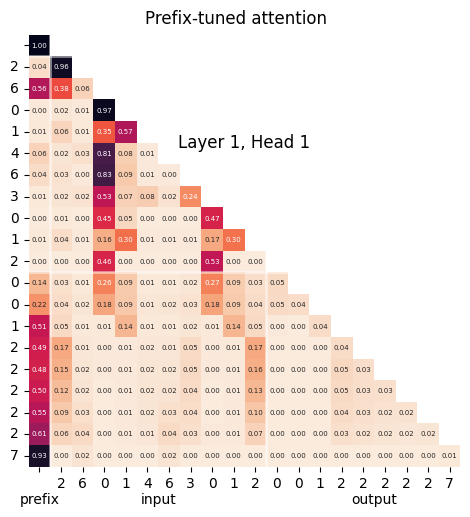

In [13]:
record = []
continuation = model.generate(torch.tensor([0]*prefix_size + [2,6,0,1,4,6,3,0,1,2], device=device).unsqueeze(0), 10, do_sample=False, activations_record=record, prefixes=prefixes)
attention_visualization(continuation[0].cpu(), record, prefix_size, train_dataset_desc.length, title="Prefix-tuned attention")
plt.savefig("01_prefixtuned.pdf")